3

In [15]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time

df = pd.read_excel('Concrete_Data.xls', sheet_name='Sheet1')
data = np.array(df)

np.random.shuffle(data)
size = math.floor(len(data) * 0.7)
train_data = data[0 : size, :]
test_data = data[size : len(data) - 1, :]

train_labels = train_data[:, -1]
test_labels = test_data[:, -1]

def preprocess(data):
    mini = np.min(data, axis=0)
    maxi = np.max(data, axis=0)
    data = (data - mini) / (maxi - mini)

    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data = (data - mean) / std

    return data

train_data = np.delete(train_data, -1, axis=1)
test_data = np.delete(test_data, -1, axis=1)

train_data = preprocess(train_data)
test_data = preprocess(test_data)

lr = 0.001
alpha = 1.2
beta = 0.5

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def leaky_relu(x):
    return np.maximum(0.01 * x, x)

def leaky_relu_derivative(x):
    return np.where(leaky_relu(x) > 0, 1, 0.01)

def compare_sign(dw_prev, dw, weight, lr):
    for i in range(len(dw)):
        for j in range(len(dw[i])):
            if(np.sign(dw_prev[i][j] * dw[i][j]) > 0):
                lr[i][j] = lr[i][j] * alpha
                weight[i][j] -= lr[i][j] * dw[i][j]
            elif(np.sign(dw_prev[i][j] * dw[i][j]) < 0):
                weight[i][j] += lr[i][j] * dw_prev[i][j]
                lr[i][j] = lr[i][j] * beta
            else:
                weight[i][j] -= lr[i][j] * dw[i][j]

    return weight, lr

def back_prop(weight1, weight2, loss_gradient, hidden_list, activation):
    i = 0
    dw2_list = []
    dw1_list = []

    for row in train_data:
            row = row.reshape(8, 1)
            dw2 = np.dot(loss_gradient[i], hidden_list[i].transpose())
            dZ = np.dot(weight2.transpose(), loss_gradient[i])

            if(activation == 'tanh'):
                dA = dZ * tanh_derivative(hidden_list[i])
            else:
                dA = dZ * leaky_relu_derivative(hidden_list[i])
                
            dw1 = np.dot(dA, row.transpose())

            dw2_list.append(dw2)
            dw1_list.append(dw1)

            i += 1

    weight1 -= lr * sum(dw1_list) / len(dw1_list)
    weight2 -= lr * sum(dw2_list) / len(dw2_list)

    return weight1, weight2

def r_prop(weight1, weight2, loss_gradient, hidden_list, activation, dw1_prev, dw2_prev, lr1, lr2):
    i = 0
    dw1_list = np.zeros((len(train_data), weight1.shape[0], weight1.shape[1]))
    dw2_list = np.zeros((len(train_data), weight2.shape[0], weight2.shape[1]))

    for row in train_data:
        row = row.reshape(8, 1)
        dw2 = np.dot(loss_gradient[i], hidden_list[i].transpose())
        dZ = np.dot(weight2.transpose(), loss_gradient[i])

        if(activation == 'tanh'):
            dA = dZ * tanh_derivative(hidden_list[i])
        else:
            dA = dZ * leaky_relu_derivative(hidden_list[i])
                
        dw1 = np.dot(dA, row.transpose())

        dw2_list[i] = dw2
        dw1_list[i] = dw1

        i += 1

    dw1 = np.mean(dw1_list, axis=0)
    dw2 = np.mean(dw2_list, axis=0)

    weight1, lr1 = compare_sign(dw1_prev, dw1, weight1, lr1)
    weight2, lr2 = compare_sign(dw2_prev, dw2, weight2, lr2)

    return weight1, weight2, dw1, dw2, lr1, lr2

def quick_prop(weight1, weight2, loss_gradient, hidden_list, activation, dw1_prev, dw2_prev, weight1_prev, weight2_prev):
    i = 0
    dw1_list = np.zeros((len(train_data), weight1.shape[0], weight1.shape[1]))
    dw2_list = np.zeros((len(train_data), weight2.shape[0], weight2.shape[1]))

    for row in train_data:
        row = row.reshape(8, 1)
        dw2 = np.dot(loss_gradient[i], hidden_list[i].transpose())
        dZ = np.dot(weight2.transpose(), loss_gradient[i])

        if(activation == 'tanh'):
            dA = dZ * tanh_derivative(hidden_list[i])
        else:
            dA = dZ * leaky_relu_derivative(hidden_list[i])
                
        dw1 = np.dot(dA, row.transpose())

        dw2_list[i] = dw2
        dw1_list[i] = dw1

        i += 1

    dw1 = np.mean(dw1_list, axis=0)
    dw2 = np.mean(dw2_list, axis=0)

    weight1 -= (lr * dw1) * np.abs((weight1 - weight1_prev) / (dw1 - dw1_prev + 1e-10))
    weight2 -= (lr * dw2) * np.abs((weight2 - weight2_prev) / (dw2 - dw2_prev + 1e-10))

    return weight1, weight2, dw1, dw2

In [24]:
def func1(weight1, weight2, hidden, output, activation, algorithm):
    lr1 = np.empty(weight1.shape)
    lr2 = np.empty(weight2.shape)
    lr1.fill(0.001)
    lr2.fill(0.001)

    dw1 = np.zeros(weight1.shape)
    dw2 = np.zeros(weight2.shape)

    weight1_prev = weight1
    weight2_prev = weight2
    
    loss_gradient = np.zeros(len(train_data))
    train_loss_list = []
    test_loss_list = []

    iterations = []
    for iteration in range(1000):
        iterations.append(iteration + 1)
        i = 0
        output_list = []
        hidden_list = []
        
        for row in train_data:
            row = row.reshape(8, 1)
            hidden = np.dot(weight1, row)

            if(activation == 'tanh'):
                hidden = tanh(hidden)
            else:
                hidden = leaky_relu(hidden)

            output = np.dot(weight2, hidden)

            output_list.append(output)
            hidden_list.append(hidden) 

            loss_gradient[i] = 2 * (output - train_labels[i])
            i += 1

        train_loss = np.mean(np.square(np.subtract(output_list, train_labels)))
        train_loss_list.append(train_loss)

        test_output_list = []
        test_hidden_list = []
        
        for row in test_data:
            row = row.reshape(8, 1)
            hidden = np.dot(weight1, row)

            if(activation == 'tanh'):
                hidden = tanh(hidden)
            else:
                hidden = leaky_relu(hidden)

            output = np.dot(weight2, hidden)

            test_output_list.append(output)
            test_hidden_list.append(hidden) 

        test_loss = np.mean(np.square(np.subtract(test_output_list, test_labels)))
        test_loss_list.append(test_loss)

        if(algorithm == 'back_prop'):
            weight1, weight2 = back_prop(weight1, weight2, loss_gradient, hidden_list, activation)
        elif (algorithm == 'r_prop'):
            weight1, weight2, dw1, dw2, lr1, lr2 = r_prop(weight1, weight2, loss_gradient, hidden_list, activation, dw1, dw2, lr1, lr2)
        else:
            if(iteration == 0):
                weight1, weight2 = back_prop(weight1, weight2, loss_gradient, hidden_list, activation)
            else:
                weight1_temp = weight1
                weight2_temp = weight2

                weight1, weight2, dw1, dw2 = quick_prop(weight1, weight2, loss_gradient, hidden_list, activation, dw1, dw2, weight1_prev, weight2_prev)
                
                weight1_prev = weight1_temp
                weight2_prev = weight2_temp

    print('Min train loss: ', min(train_loss_list))
    print('Min test loss: ', min(test_loss_list))

    plt.plot(iterations, train_loss_list, label='Train Loss')
    plt.plot(iterations, test_loss_list, label='Test Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()    

Min train loss:  1065.1627654387357
Min test loss:  1097.5401122939536


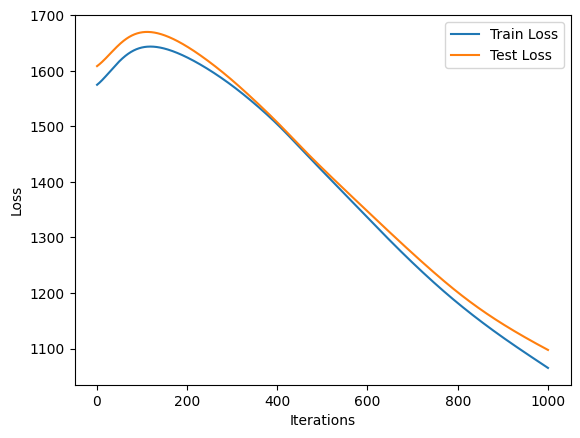

Time taken :  13.307615041732788


In [29]:
weight1 = np.random.rand(25, 8)
hidden = np.zeros((25, 1))
weight2 = np.random.rand(1, 25)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='tanh', algorithm='back_prop')
print('Time taken : ', time.time() - prev_time)

Min train loss:  807.2266742912249
Min test loss:  872.4263437966862


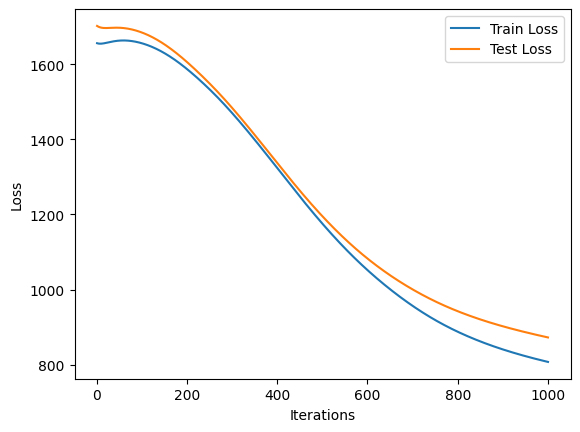

Time taken :  13.748482942581177


In [30]:
weight1 = np.random.rand(50, 8)
hidden = np.zeros((50, 1))
weight2 = np.random.rand(1, 50)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='tanh', algorithm='back_prop')
print('Time taken : ', time.time() - prev_time)

Min train loss:  472.63961521711303
Min test loss:  533.1843761313473


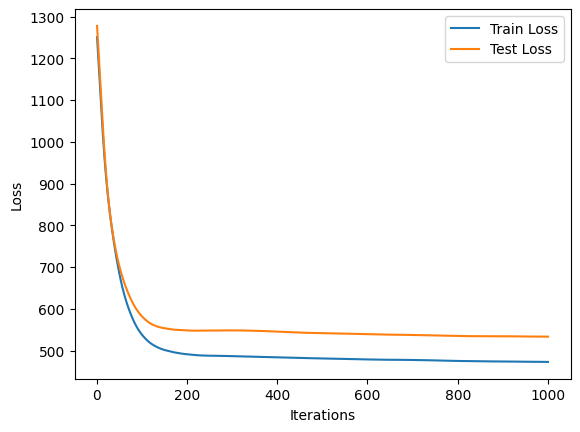

Time taken :  15.897460460662842


In [31]:
weight1 = np.random.rand(25, 8)
hidden = np.zeros((25, 1))
weight2 = np.random.rand(1, 25)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='leaky_relu', algorithm='back_prop')
print('Time taken : ', time.time() - prev_time)

Min train loss:  475.3208188429154
Min test loss:  532.4699329747061


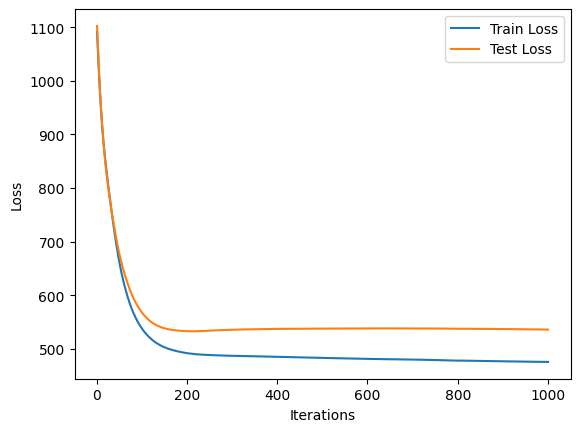

Time taken :  17.702815055847168


In [32]:
weight1 = np.random.rand(50, 8)
hidden = np.zeros((50, 1))
weight2 = np.random.rand(1, 50)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='leaky_relu', algorithm='back_prop')
print('Time taken : ', time.time() - prev_time)

Min train loss:  664.5773427397668
Min test loss:  763.9904464643511


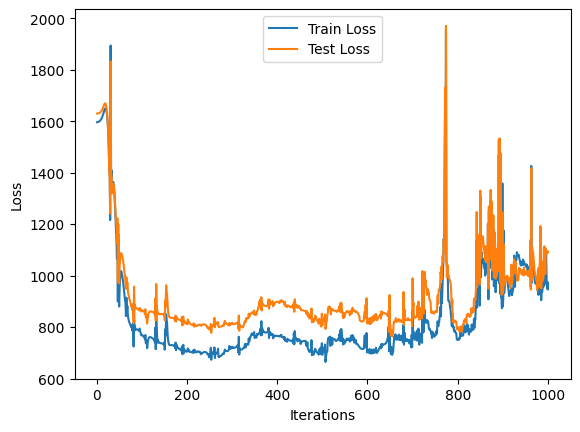

Time taken :  14.963841199874878


In [33]:
weight1 = np.random.rand(25, 8)
hidden = np.zeros((25, 1))
weight2 = np.random.rand(1, 25)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='tanh', algorithm='r_prop')
print('Time taken : ', time.time() - prev_time)

Min train loss:  595.4680506736908
Min test loss:  735.6941760006973


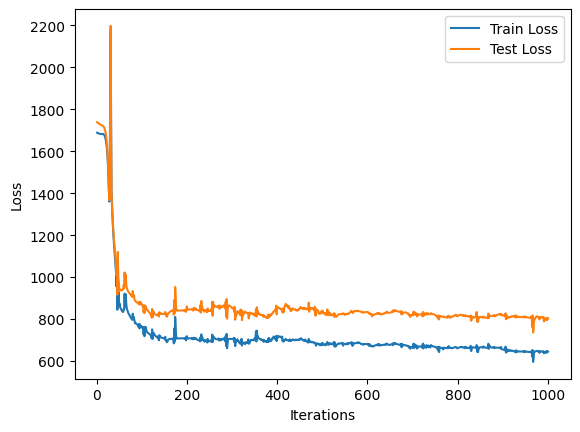

Time taken :  14.680502891540527


In [34]:
weight1 = np.random.rand(50, 8)
hidden = np.zeros((50, 1))
weight2 = np.random.rand(1, 50)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='tanh', algorithm='r_prop')
print('Time taken : ', time.time() - prev_time)

Min train loss:  449.26341864494674
Min test loss:  502.57167522980205


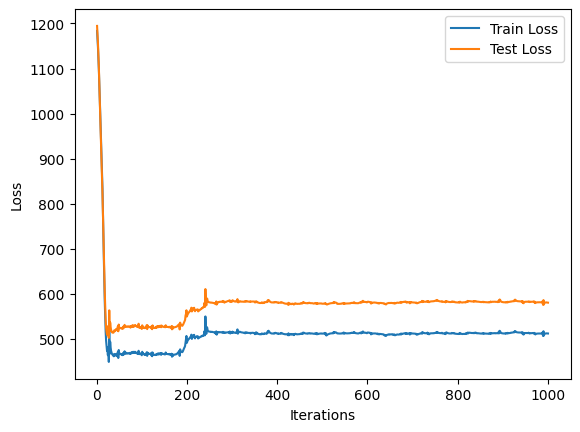

Time taken :  17.563912391662598


In [35]:
weight1 = np.random.rand(25, 8)
hidden = np.zeros((25, 1))
weight2 = np.random.rand(1, 25)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='leaky_relu', algorithm='r_prop')
print('Time taken : ', time.time() - prev_time)

Min train loss:  450.21836773440725
Min test loss:  498.3912266117072


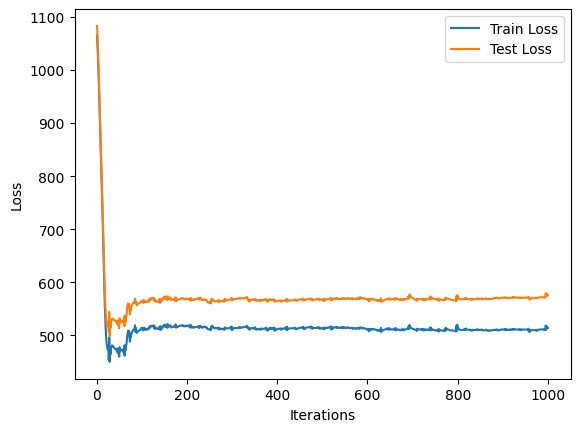

Time taken :  17.382912158966064


In [36]:
weight1 = np.random.rand(50, 8)
hidden = np.zeros((50, 1))
weight2 = np.random.rand(1, 50)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='leaky_relu', algorithm='r_prop')
print('Time taken : ', time.time() - prev_time)

True
Min train loss:  1601.0612406341938
Min test loss:  1631.6795472680446


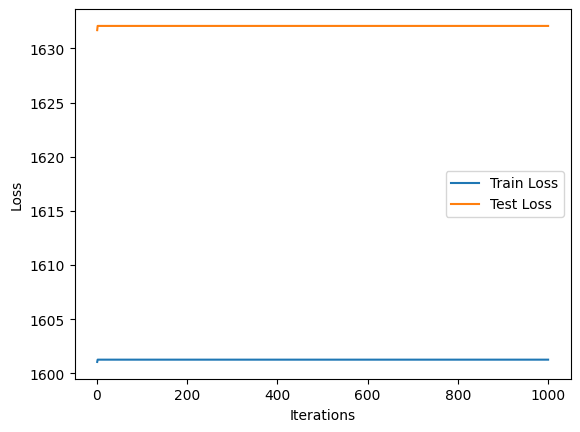

Time taken :  14.644834756851196


In [25]:
weight1 = np.random.rand(25, 8)
hidden = np.zeros((25, 1))
weight2 = np.random.rand(1, 25)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='tanh', algorithm='quick_prop')
print('Time taken : ', time.time() - prev_time)

Min train loss:  1677.1854405271972
Min test loss:  1701.9784156096343


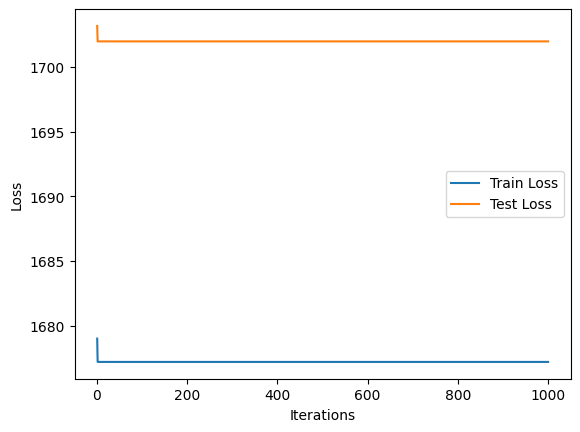

Time taken :  15.77492356300354


In [6]:
weight1 = np.random.rand(50, 8)
hidden = np.zeros((50, 1))
weight2 = np.random.rand(1, 50)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='tanh', algorithm='quick_prop')
print('Time taken : ', time.time() - prev_time)

Min train loss:  1234.782583113795
Min test loss:  1153.172250072598
Epochs to convergence:  1


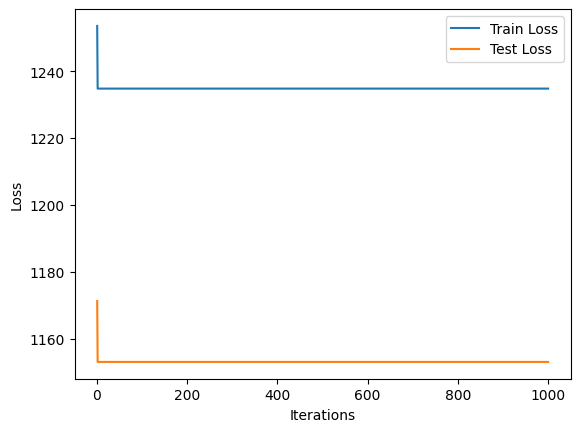

Time taken :  46.94172954559326


In [50]:
weight1 = np.random.rand(25, 8)
hidden = np.zeros((25, 1))
weight2 = np.random.rand(1, 25)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='leaky_relu', algorithm='quick_prop')
print('Time taken : ', time.time() - prev_time)

Min train loss:  1079.6675851311727
Min test loss:  1004.9973911447944
Epochs to convergence:  1


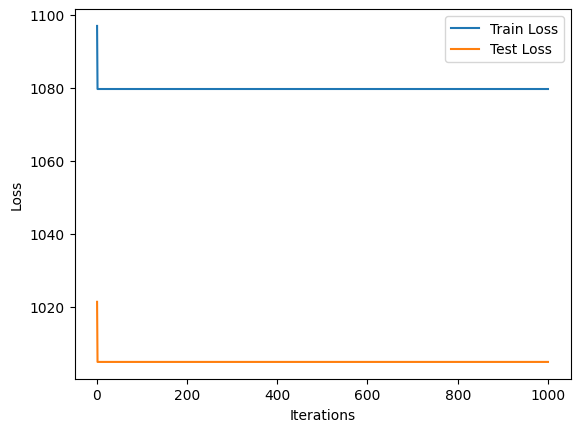

Time taken :  46.77287530899048


In [51]:
weight1 = np.random.rand(50, 8)
hidden = np.zeros((50, 1))
weight2 = np.random.rand(1, 50)
output = np.zeros((1, 1))

prev_time = time.time()
func1(weight1, weight2, hidden, output, activation='leaky_relu', algorithm='quick_prop')
print('Time taken : ', time.time() - prev_time)

Lowest loss : 
    Algorithm : R_Prop
    Activation : Leaky_ReLU
    No of hidden units : 50

Minimum time for epochs:
    Algorithm : Back_Prop
    Activation : Tanh
    No of hidden units : 25